In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import yaml

from pyoperators import *
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

import qubic
from qubic.lib.Calibration.Qselfcal import scatter_plot_FP, get_TEScoordinates_ONAFP
from qubic.lib.InstrumentModel.Qinstrument import QubicInstrument
from qubic.lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions
from qubic.lib.MapMaking.Qmaps import InputMaps
from qubic.lib.Qsamplings import get_pointing
%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Nsub_in

In [2]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
        "beam_shape": 'gaussian',
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [3]:
def get_sky_config(params, comm):
        """Sky configuration.

        Method that read 'params.yml' file and create dictionary containing sky emission model.

        Returns
        -------
        dict_sky: dict
            Sky config dictionary.

        Notes
        -----
        Note that the key denote the emission and the value denote the sky model using PySM convention.
        For CMB, seed denote the realization.

        Example
        -------
        d = {'cmb':seed, 'dust':'d0', 'synchrotron':'s0'}

        """

        dict_sky = {}

        if params["CMB"]["cmb"]:
            if params["CMB"]["seed"] == 0:
                if comm.Get_rank() == 0:
                    seed = np.random.randint(10000000)
                else:
                    seed = None
                seed = comm.bcast(seed, root=0)
            else:
                seed = params["CMB"]["seed"]
                
            dict_sky["cmb"] = seed

        for j in params["Foregrounds"]:
            # print(j, params['Foregrounds'][j])
            if j == "Dust":
                if params["Foregrounds"][j]:
                    dict_sky["dust"] = "d0"
            elif j == "Synchrotron":
                if params["Foregrounds"][j]:
                    dict_sky["synchrotron"] = "s0"

        return dict_sky

In [4]:
# Initialize pipeline arguments
comm = MPI.COMM_WORLD

with open('params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [5]:
# Acquisition arguments
dict_qubic = get_dict(params, comm)

nsub_list = np.arange(4, 41, 4)
print(nsub_list)

det_index = 400
sampling_index = 0


[ 4  8 12 16 20 24 28 32 36 40]


In [6]:
sky = get_sky_config(params, comm)
sampling = get_pointing(dict_qubic)
q = QubicInstrument(dict_qubic)

You asked 100 pointings with repeat strategy so I will provide 33 pointings repeated 3 times.


In [7]:
sampling.angle_hwp = sampling.angle_hwp

# Sub-TOD

In [10]:
nsub_max = 40
nsub_list = np.arange(0, nsub_max)

In [11]:
acq = QubicMultiAcquisitions(dict_qubic, nsub_max*2, params['QUBIC']['nrec'], sampling=sampling)
ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])

H = acq.H[:nsub_max]
input_maps = ext.m_nu
input_maps_ones = np.ones(np.shape(input_maps))

Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.


In [12]:
TOD_ones = []
for i in range(nsub_max):
    C = HealpixConvolutionGaussianOperator(0)
    TOD_ones.append(H[i](C(input_maps_ones[i])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x7cbe140efa00>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28'),
  Text(30, 0, '30'),
  Text(32, 0, '32'),
  Text(34, 0, '34'),
  Text(36, 0, '36'),
  Text(38, 0, '38')])

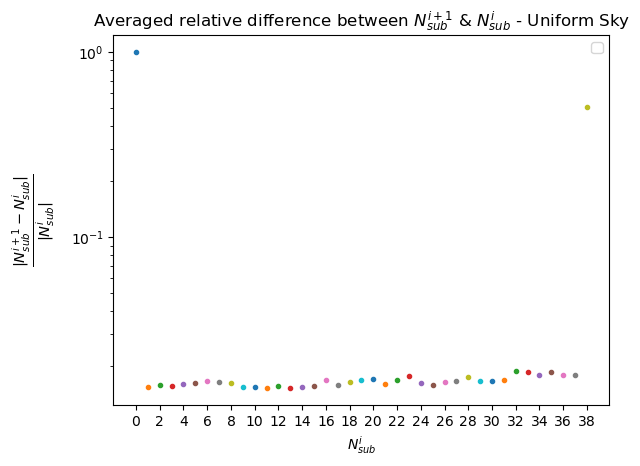

In [13]:
plt.figure()
for i in range(nsub_max-1):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones[i+1] - TOD_ones[i])/TOD_ones[i])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{i+1}$ & $N_{sub}^i$ - Uniform Sky")
plt.ylabel(r'$\frac{| N_{sub}^{i+1} - N_{sub}^i |}{| N_{sub}^{i} |}$', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')
plt.xticks(np.arange(0, nsub_max-1, 2))

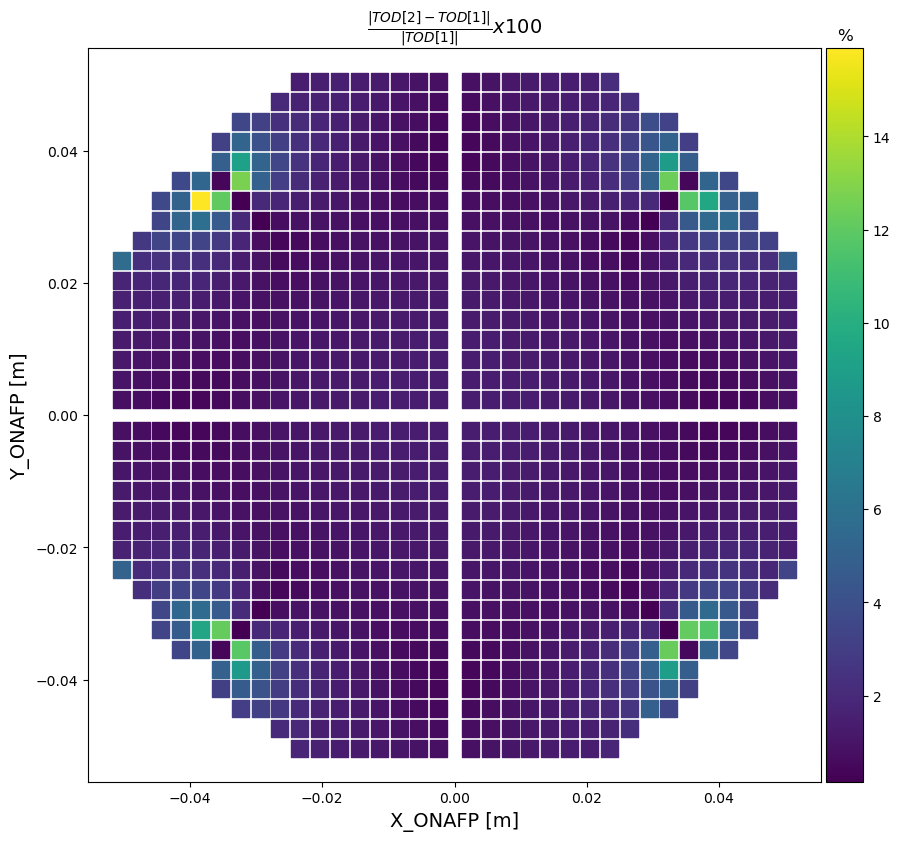

In [14]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones[2] - TOD_ones[1]) / np.abs(TOD_ones[1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD[2] - TOD[1] |}{| TOD[1] |} x 100$', fig=fig, ax = ax, unit='%')

# Operators details

In [15]:
H[0].operands

[ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,99), shapeout=(992,99)),
 DiagonalOperator(array([0.00032448573087862873, ..., 0.00032448573087862873], dtype=float64), broadcast='rightward', None),
 ReshapeOperator((992,99,1), (992,99), None),
 DenseBlockDiagonalOperator(array([[[[2.5693506054731077e-21, ..., -2.2251228955686392e-21]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,99,3), shapeout=(992,99,1)),
 ProjectionOperator(None, None, shapein=(49152,3), shapeout=(992,99,3))]

In [16]:
Rdet_list = []
Tinst_list = []
Idet_list = []
Pol_list = []
Proj_list = []
Hwp_list = []
Filt_list = []
Ap_list = []
Unit_list = []
C_list = []
for i in range(nsub_max):
    Rdet_list.append(acq.subacqs[0].get_detector_response_operator())
    Tinst_list.append(acq.multiinstrument[i].get_transmission_operator())
    Idet_list.append(acq.subacqs[i].get_detector_integration_operator())
    Pol_list.append(acq.subacqs[i].get_polarizer_operator())
    Proj_list.append(acq.subacqs[i].get_projection_operator())
    Hwp_list.append(acq.multiinstrument[i].get_hwp_operator(sampling, acq.scene))
    Filt_list.append(acq.subacqs[i].get_filter_operator())
    Ap_list.append(acq.subacqs[i].get_aperture_integration_operator())
    Unit_list.append(acq.subacqs[i].get_unit_conversion_operator())
    C_list.append(HealpixConvolutionGaussianOperator(acq.allfwhm[i]))

Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.


## Input Maps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

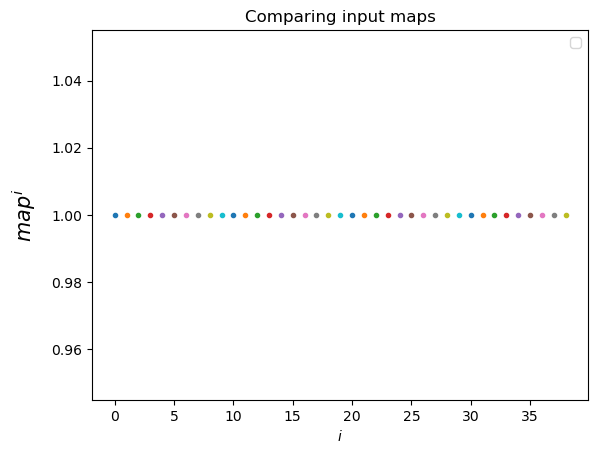

In [17]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(input_maps_ones[i]), '.')
plt.legend()
plt.title(r"Comparing input maps")
plt.ylabel(r'$map^i$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

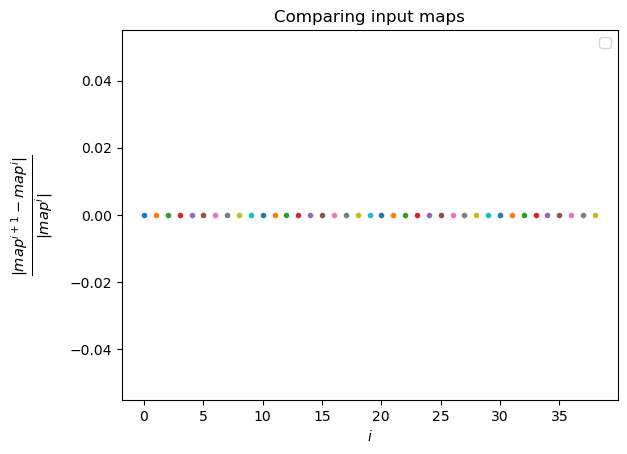

In [18]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((input_maps_ones[i+1] - input_maps_ones[i])/input_maps_ones[i])), '.')
plt.legend()
plt.title(r"Comparing input maps")
plt.ylabel(r'$\frac{| map^{i+1} - map^i |}{| map^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

GOOD

## Convolution operator

In [19]:
test_conv = []
for i in range(nsub_max):
    C = C_list[i]
    test_conv.append(C(input_maps_ones[i]))

In [93]:
test_conv[0].shape

(49152, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

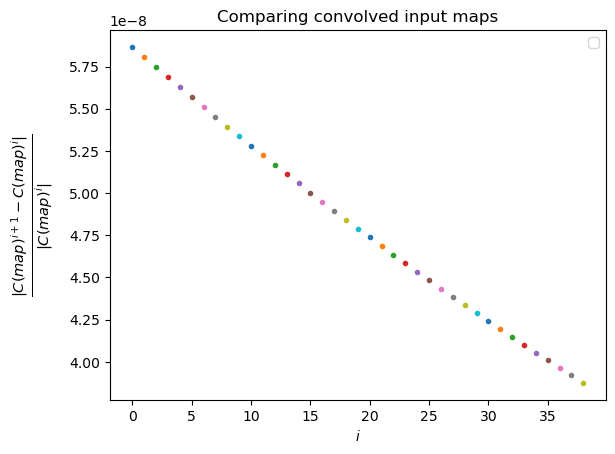

In [94]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_conv[i+1] - test_conv[i])/test_conv[i])), '.')
plt.legend()
plt.title(r"Comparing convolved input maps")
plt.ylabel(r'$\frac{| C(map)^{i+1} - C(map)^i |}{| C(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$Nsub_i$')

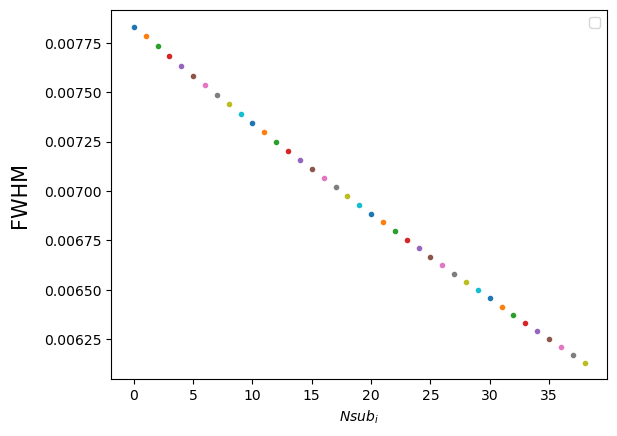

In [21]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], acq.allfwhm[i], '.')
plt.legend()
plt.ylabel(r'FWHM', fontsize=15, labelpad=10)
plt.xlabel(r'$Nsub_i$')

OK

## Temperature Operator

In [22]:
test_temp = []
for i in range(nsub_max):
    Unit = Unit_list[i]
    test_temp.append(Unit(input_maps_ones[i]))

In [23]:
test_temp[0].shape

(49152, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

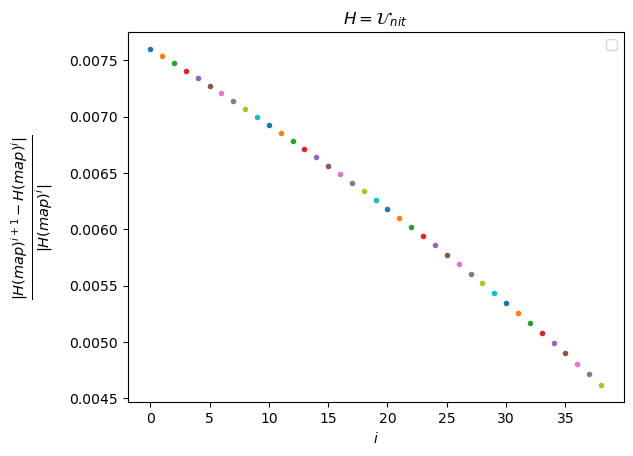

In [109]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_temp[i+1] - test_temp[i])/test_temp[i])), '.')
plt.legend()
plt.title(r"$H = \mathcal{U}_{nit}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

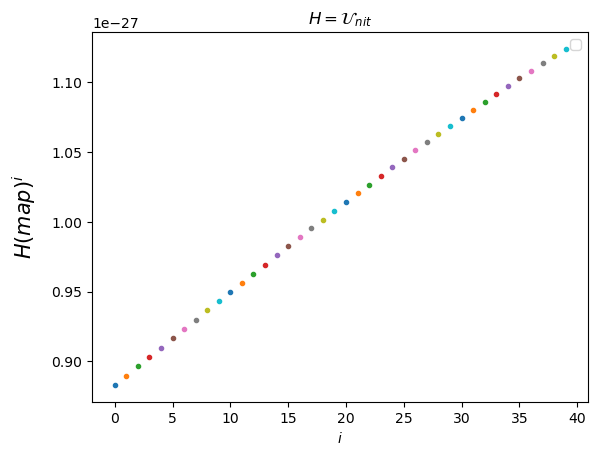

In [25]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(test_temp[i][..., 0]), '.')
plt.legend()
plt.title(r"$H = \mathcal{U}_{nit}$")
plt.ylabel(r'$H(map)^i$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

$\mathcal{U}_{nit} = \frac{10^{-6}}{T} \frac{2\Omega_{pix}h\nu^3}{c^2} \frac{h\nu}{kT} \frac{e^{\frac{h\nu}{kT}}}{(e^{\frac{h\nu}{kT}} - 1)^2}$

In [26]:
from scipy.constants import c, h, k
def u_nit(nu):
    a = 2 * acq.scene.solid_angle * h * nu**3 / c**2
    T = acq.scene.temperature
    hnu_kt = h * nu / k / T
    return 1e-6 * a * hnu_kt * np.exp(hnu_kt) / (np.expm1(hnu_kt)**2 * T)

Text(0, 0.5, '$\\mathcal{U}_{nit} (W / m^2 / Hz / K)$')

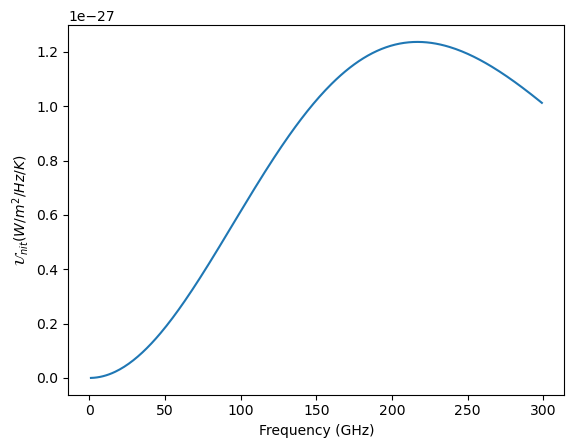

In [104]:
plt.plot(u_nit(np.linspace(0, 300, 300)*1e9))
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$\mathcal{U}_{nit} (W / m^2 / Hz / K)$')

Text(0.5, 1.0, '$\\mathcal{U}_{nit}$')

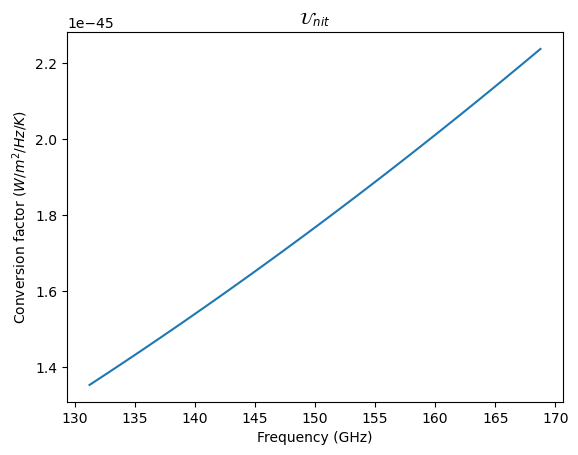

In [28]:
plt.plot(acq.allnus[:nsub_max], u_nit(acq.allnus[:nsub_max]))
plt.xlabel("Frequency (GHz)")
plt.ylabel(r'Conversion factor ($W / m^2 / Hz / K$)')
plt.title(r'$\mathcal{U}_{nit}$')

In [29]:
a = asoperator(u_nit(acq.allnus[0]))(input_maps_ones[0])[..., 0]
b = asoperator(u_nit(acq.allnus[1]))(input_maps_ones[1])[..., 0]

1.3531288902990119e-45
1.3706807670155726e-45
0.012971326562011505


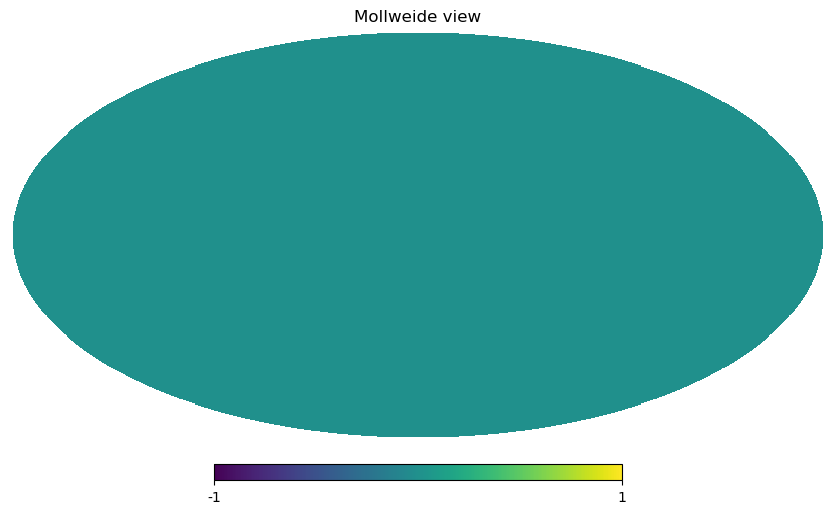

In [30]:
hp.mollview(a)
print(a[0])
print(b[0])
print(np.abs(a[0] - b[0])/a[0])

## Transmitivity atmosphere

In [31]:
acq.scene.atmosphere.transmission

1.0

## Aperture Operator

Convert $W / m^2 / Hz$ to $W / Hz$.
It is a homothety of value $ \lambda = N_{horn}S_{horn} = N_{horn}\pi r^2$

In [32]:
test_ap = []
for i in range(nsub_max):
    Ap = Ap_list[i]
    test_ap.append(Ap(input_maps_ones[i]))

In [33]:
test_ap[0].shape

(49152, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

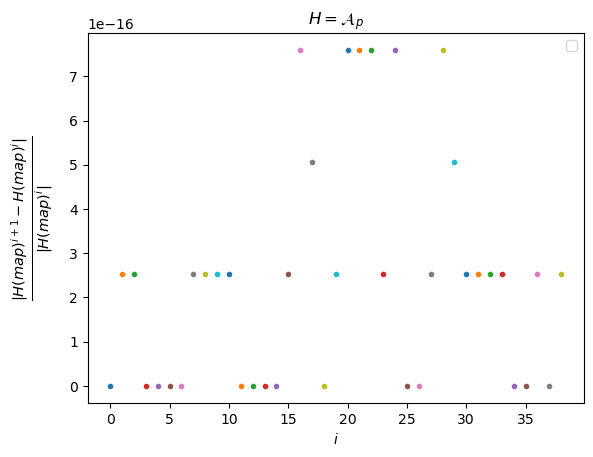

In [110]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_ap[i+1] - test_ap[i])/test_ap[i])), '.')
plt.legend()
plt.title(r"$H = \mathcal{A}_p$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

Text(0, 0.5, 'Effective horn radius')

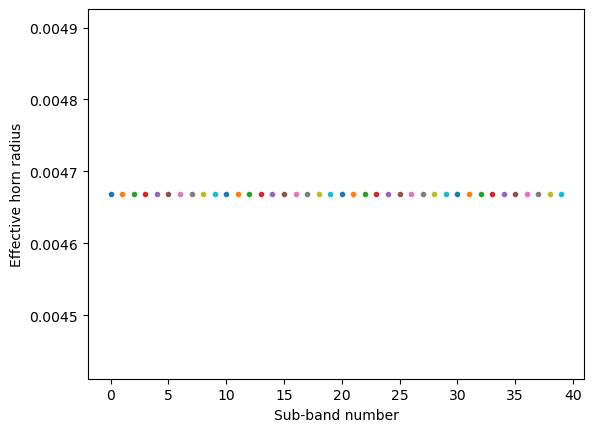

In [117]:
for i in range(nsub_max):
    plt.plot(nsub_list[i], acq.multiinstrument[i].horn.radeff, '.')
plt.xlabel('Sub-band number')
plt.ylabel('Effective horn radius')

## Filter operator

In [35]:
test_filt = []
for i in range(nsub_max):
    Filt = Filt_list[i]
    test_filt.append(Filt(input_maps_ones[i]))

In [36]:
test_filt[0].shape

(49152, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


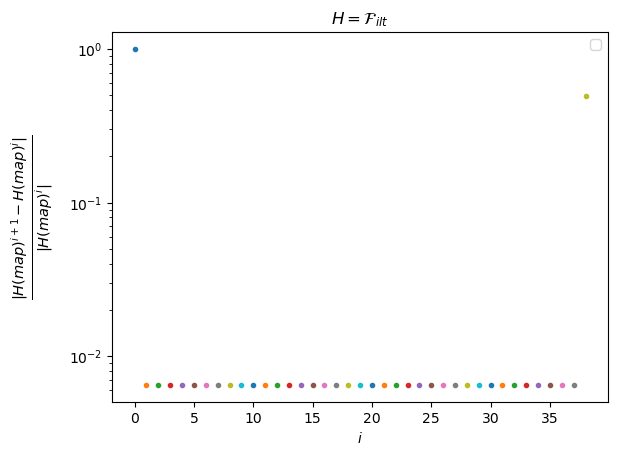

In [37]:
plt.figure()
for i in range(0, len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_filt[i+1][..., 0] - test_filt[i][..., 0])/test_filt[i][..., 0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{F}_{ilt}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')
plt.yscale('log')

Text(0, 0.5, 'Filter bandwidth (GHz)')

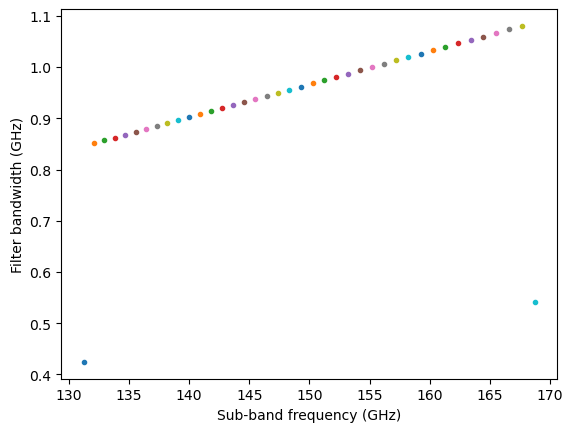

In [91]:
bandwidth_list = []
for i in range(nsub_max):
    bandwidth_list.append(acq.multiinstrument[i].filter.bandwidth/1e9)
    plt.plot(acq.allnus[i], acq.multiinstrument[i].filter.bandwidth/1e9, '.')
plt.xlabel('Sub-band frequency (GHz)')
plt.ylabel('Filter bandwidth (GHz)')

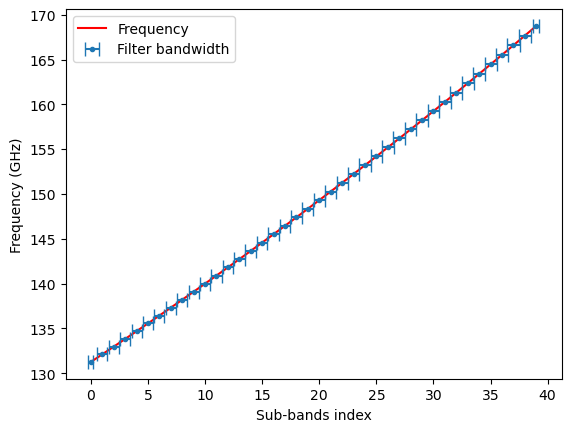

In [160]:
plt.plot(nsub_list, acq.allnus[:nsub_max], 'r', label='Frequency')
plt.errorbar(nsub_list, acq.allnus[:nsub_max], xerr=np.array(bandwidth_list)/2,fmt='.',label='Filter bandwidth', capsize=5)
plt.xlabel('Sub-bands index')
plt.ylabel('Frequency (GHz)')
plt.legend()

In [155]:
def create_number_line(values):
    fig, ax = plt.subplots(figsize=(10, 1))  # Taille de la figure

    # Configuration des graduations
    ax.set_xticks(values)  # Utilisation des valeurs de la liste pour les graduations
    ax.set_yticks([])      # Pas de graduations sur l'axe y

    # Modification du style de la ligne
    ax.spines['top'].set_visible(False)    # Masquer le bord supérieur
    ax.spines['right'].set_visible(False)  # Masquer le bord droit
    ax.spines['left'].set_visible(False)   # Masquer le bord gauche

    # Affichage de la ligne
    ax.plot([0, max(values)], [0, 0], color='k', linewidth=2)  # Ligne principale

    # Affichage des graduations
    for value in values:
        ax.plot([value, value], [-0.1, 0.1], color='k', linewidth=1)  # Lignes de graduation

    plt.show()

# Exemple d'utilisation
test = []
test.append(0)
for i in range(1, nsub_max+1):
    test.append(test[i-1] + bandwidth_list[i]) 
create_number_line(bandwidth_list)

IndexError: list index out of range

## Projection Operator

In [38]:
test_proj = []
for i in range(nsub_max):
    Proj = Proj_list[i]
    test_proj.append(Proj(input_maps_ones[i]))

In [39]:
test_proj[0].shape

(992, 99, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

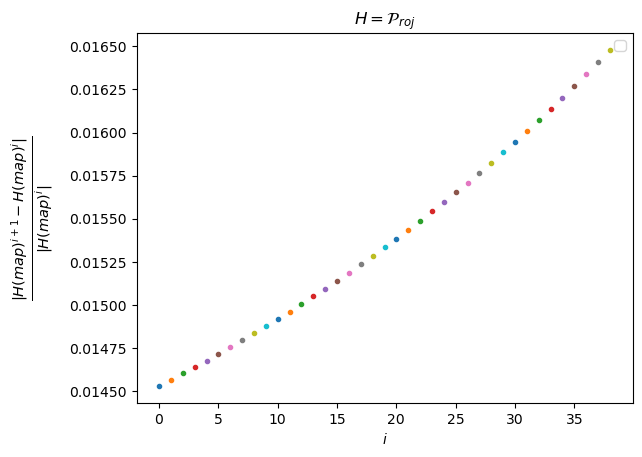

In [40]:
plt.figure()
for i in range(len(nsub_list)-1):
    diff = np.abs((test_proj[i+1][..., 0] - test_proj[i][..., 0])/test_proj[i][..., 0])
    # Need to remove 'nan' due to division by 0
    mean_diff = np.mean(diff[~np.isnan(diff)])
    plt.plot(nsub_list[i], mean_diff, '.')
plt.legend()
plt.title(r"$H = \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Half-Wave Plate Operator

In [41]:
test_hwp = []
for i in range(nsub_max):
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_hwp.append((Hwp * Proj)(input_maps_ones[i]))

In [42]:
test_hwp[0].shape

(992, 99, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

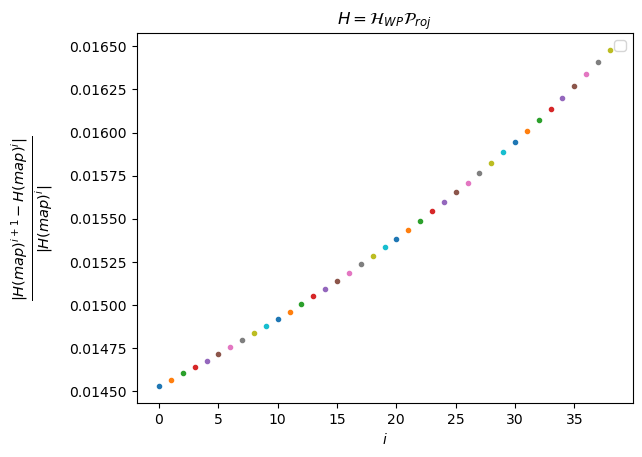

In [43]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_hwp[i+1][..., 0] - test_hwp[i][..., 0])/test_hwp[i][..., 0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Polarizer Operator

In [44]:
test_pol = []
for i in range(nsub_max):
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_pol.append((Pol * Hwp * Proj)(input_maps_ones[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

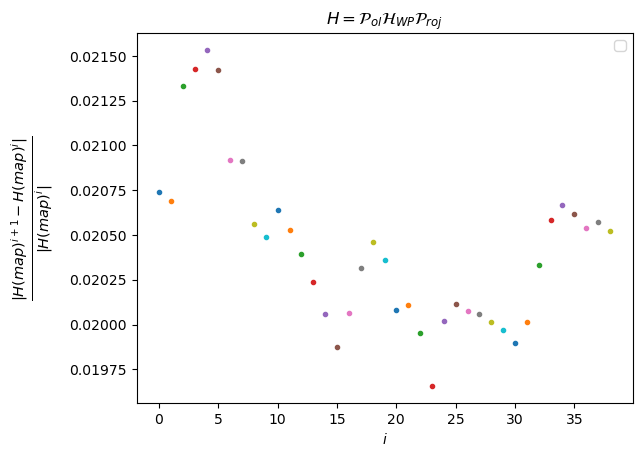

In [45]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_pol[i+1][..., 0] - test_pol[i][..., 0])/test_pol[i][..., 0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Detector Integration Operator

In [46]:
test_idet = []
for i in range(nsub_max):
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_idet.append((Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.021006147825016818


Text(0.5, 0, '$i$')

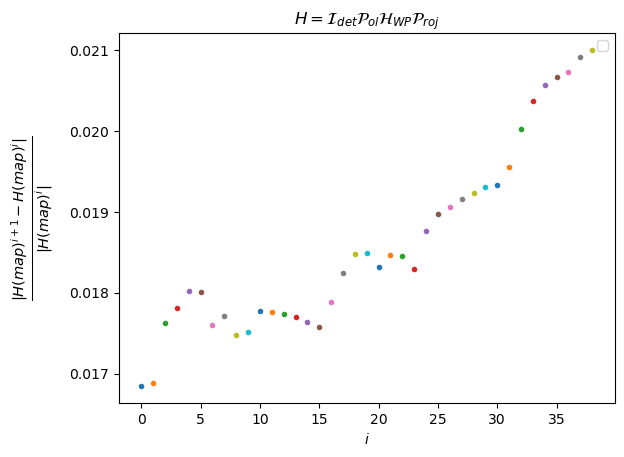

In [47]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_idet[i+1][..., 0] - test_idet[i][..., 0])/test_idet[i][..., 0])), '.')
print(np.mean(np.abs((test_idet[i+1][..., 0] - test_idet[i][..., 0])/test_idet[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Transmission Operator

In [48]:
test_trans = []
for i in range(nsub_max):
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_trans.append((Tinst * Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.021006147825016818


Text(0.5, 0, '$i$')

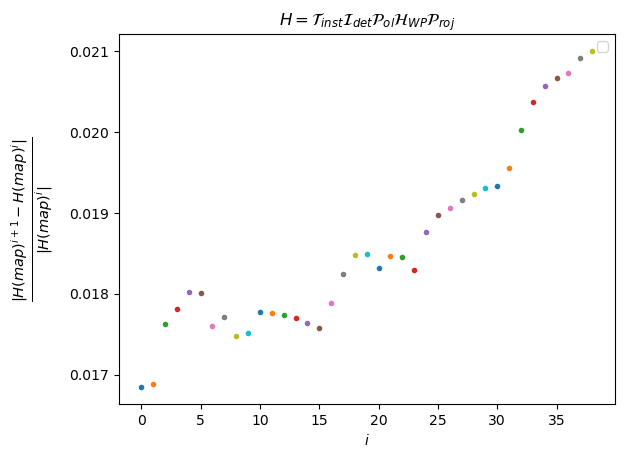

In [49]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_trans[i+1][..., 0] - test_trans[i][..., 0])/test_trans[i][..., 0])), '.')
print(np.mean(np.abs((test_trans[i+1][..., 0] - test_trans[i][..., 0])/test_trans[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Detector Response Operator

In [50]:
test_resp = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_resp.append((Rdet * Tinst * Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.021006147825016818


Text(0.5, 0, '$i$')

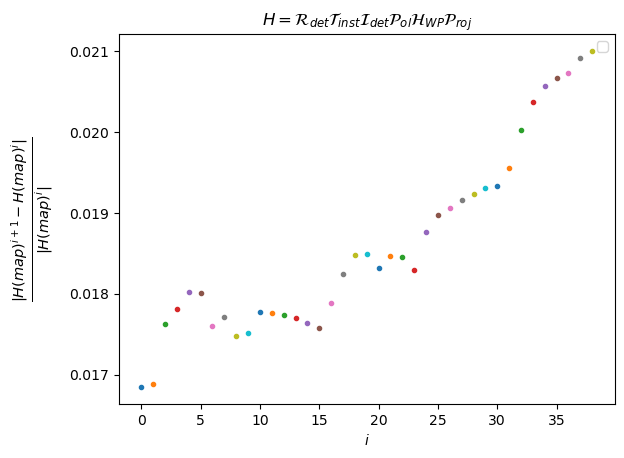

In [51]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_resp[i+1][..., 0] - test_resp[i][..., 0])/test_resp[i][..., 0])), '.')
print(np.mean(np.abs((test_resp[i+1][..., 0] - test_resp[i][..., 0])/test_resp[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Add the first conversion operators

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5072888551410872


Text(0.5, 0, '$i$')

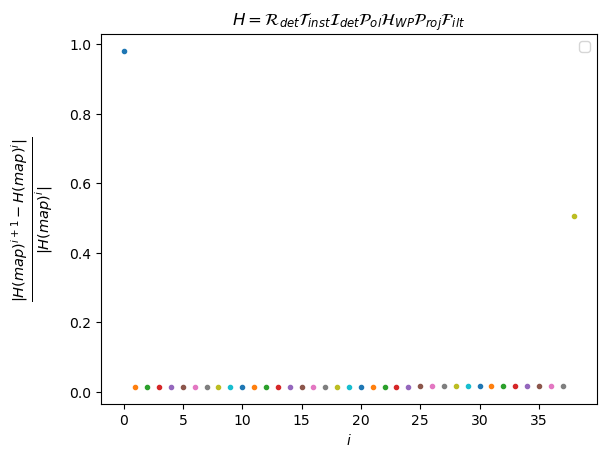

In [52]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])), '.')
print(np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5072888551410871


Text(0.5, 0, '$i$')

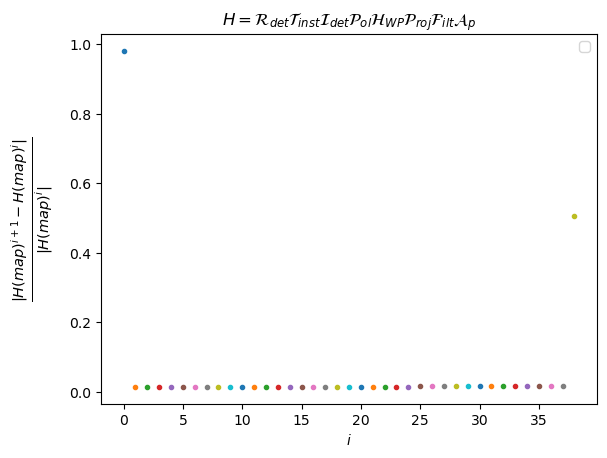

In [53]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])), '.')
print(np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.505013492351268


Text(0.5, 0, '$i$')

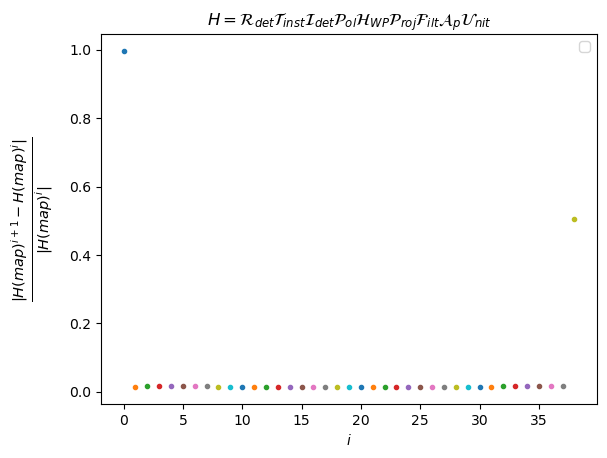

In [54]:
test = []

for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    Unit = Unit_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap * Unit)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])), '.')
print(np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p \mathcal{U}_{nit} $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5050071970875045


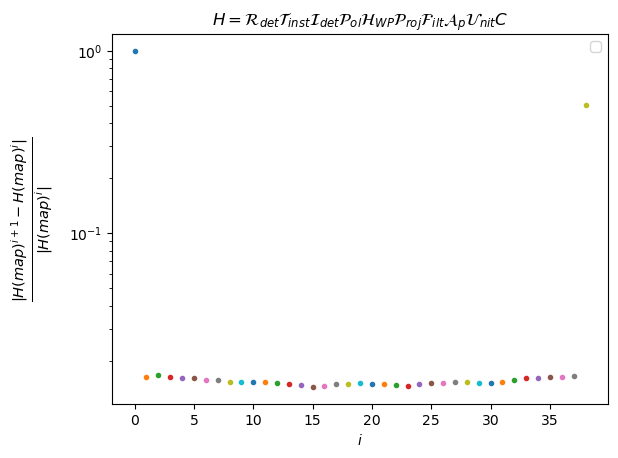

In [55]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    Unit = Unit_list[i]
    C = C_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap * Unit * C)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])), '.')
print(np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p \mathcal{U}_{nit} C $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')
plt.yscale('log')

Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (98208,9) elements = 13.48681640625 MiB in FSRRotation3dMatrix.__init__.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5050071970875045


Text(0.5, 0, '$i$')

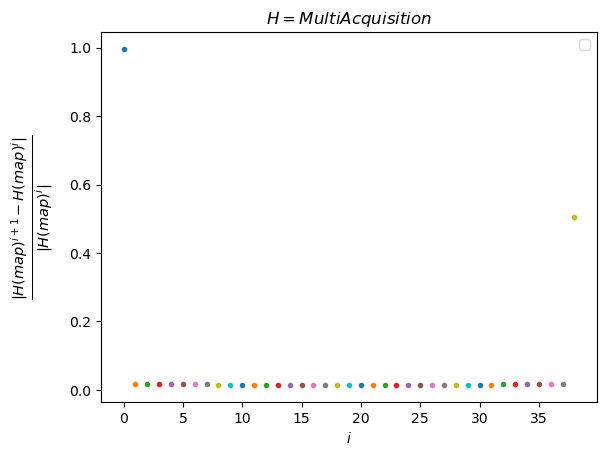

In [58]:
test = []
for i in range(nsub_max):
    H_i = acq.subacqs[i].get_operator()
    test.append(H_i(C_list[i](input_maps_ones[i])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5050071970875045


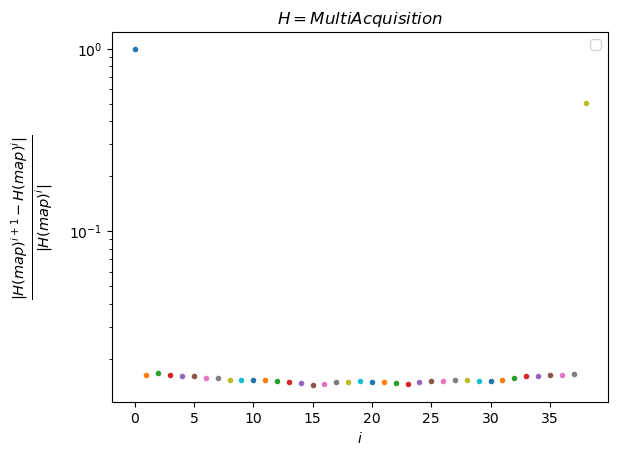

In [59]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])), '.')
print(np.mean(np.abs((test[i+1][..., 0] - test[i][..., 0])/test[i][..., 0])))
plt.legend()
plt.title(r"$H = MultiAcquisition $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')
plt.yscale('log')

# CMB

In [ ]:
# TOD_list = []
# TOD_ones_list = []
# for isub in nsub_list:
#     print(isub)
    
#     TOD = []
#     TOD_ones = []
#     acq = QubicMultiAcquisitions(dict_qubic, isub, params['QUBIC']['nrec'], sampling=sampling)
#     ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])
    
#     H = acq.H[:int(isub/2)]
#     input_maps = ext.m_nu
#     input_maps_ones = np.ones(np.shape(input_maps))
    
#     for i in range(int(isub/2)):
#         C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
#         TOD.append(H[i](C(input_maps[i])))
#         TOD_ones.append(H[i](C(input_maps_ones[i])))
#     TOD_list.append(np.sum(TOD, axis=0))
#     TOD_ones_list.append(np.sum(TOD_ones, axis=0))
# nsub_list = np.arange(4, int(i/2), 4)

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.plot(sampling.index, TOD[-1][det_index], label=f'Nsub = {nsub_list[-1]}', color='black', lw=5)
# #plt.plot(sampling.index, TOD_list[5][det_index], label=f'Nsub = {nsub_list[5]}')
# plt.plot(sampling.index, TOD[4][det_index], label=f'Nsub = {nsub_list[4]}')
# plt.plot(sampling.index, TOD[1][det_index], label=f'Nsub = {nsub_list[1]}')
# #plt.plot(sampling.index, TOD_list[0][det_index], label=f'Nsub = {nsub_list[0]}')
# plt.legend()

In [57]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_list[i][det_index][sampling_index], '.')
plt.legend()
plt.title('TOD value for a given detector at a given moment - CMB')
plt.xlabel('Nsub input')

NameError: name 'TOD_list' is not defined

<Figure size 640x480 with 0 Axes>

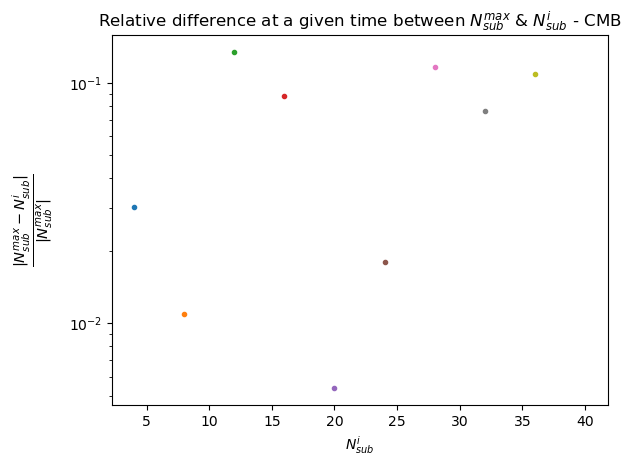

In [14]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_list[-1][det_index, sampling_index] - TOD_list[i][det_index, sampling_index])/TOD_list[-1][det_index, sampling_index]), '.')
plt.title(r"Relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')
plt.yscale('log')

Text(0.5, 0, '$N_{sub}^i$')

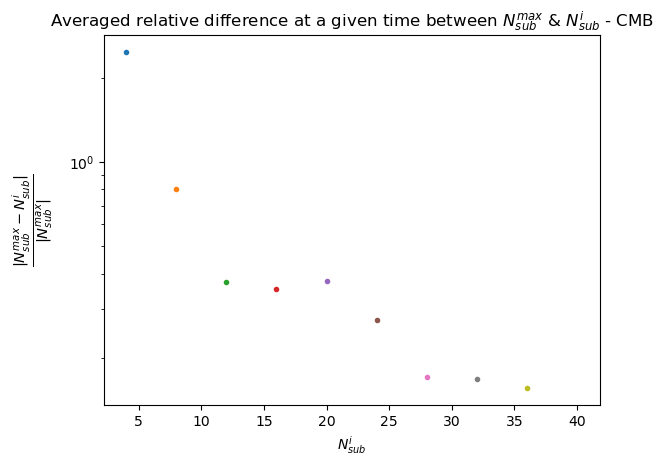

In [15]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1][:, sampling_index] - TOD_list[i][:, sampling_index])/TOD_list[-1][:, sampling_index])), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

Text(0.5, 0, '$N_{sub}^i$')

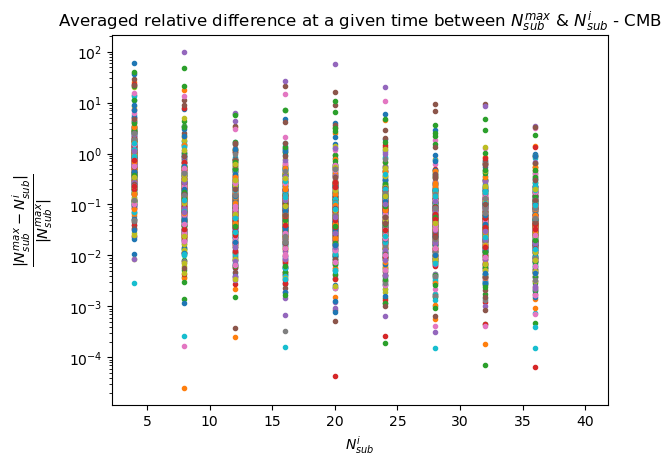

In [16]:
plt.figure()
for i in range(len(nsub_list)):
    for jdet in range(400):
        plt.plot(nsub_list[i], np.abs((TOD_list[-1][jdet, sampling_index] - TOD_list[i][jdet, sampling_index])/TOD_list[-1][jdet, sampling_index]), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

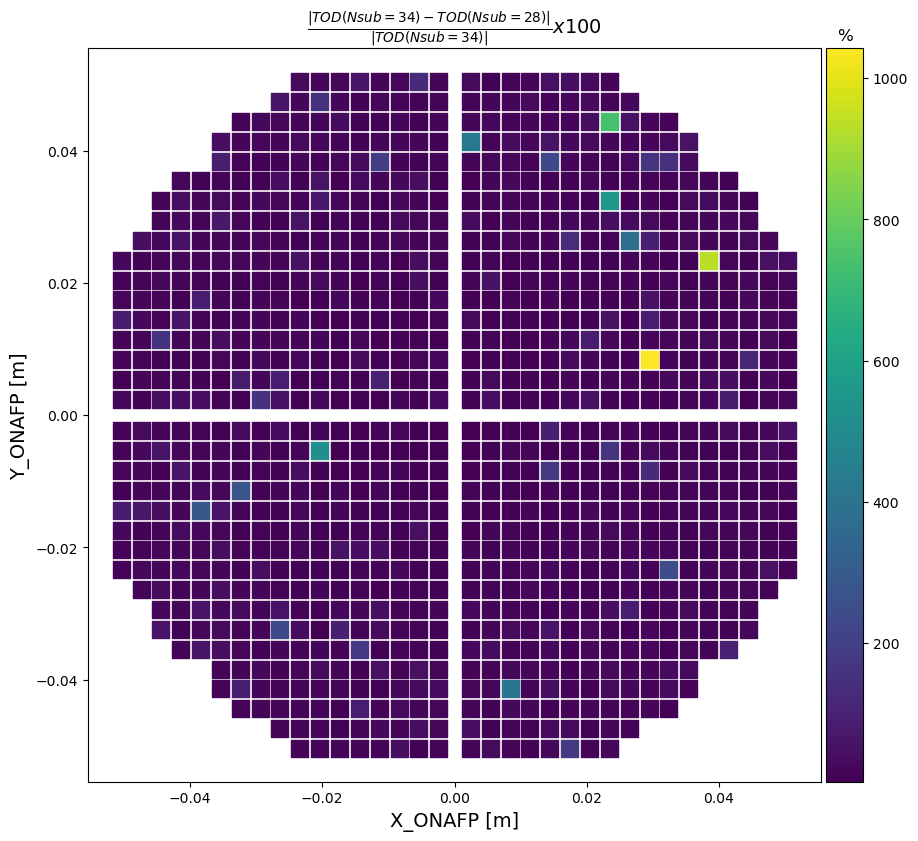

In [17]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_list[-1] - TOD_list[-2]) / np.abs(TOD_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |} x 100$', fig=fig, ax = ax, unit='%')

Text(0.5, 0, '$N_{sub}^i$')

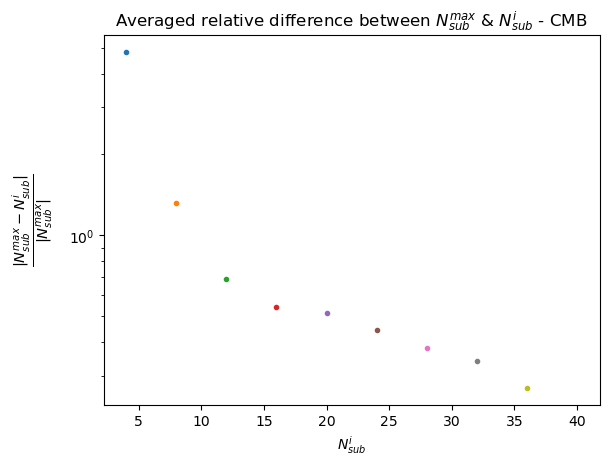

In [18]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1]), axis=0)), '.')
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

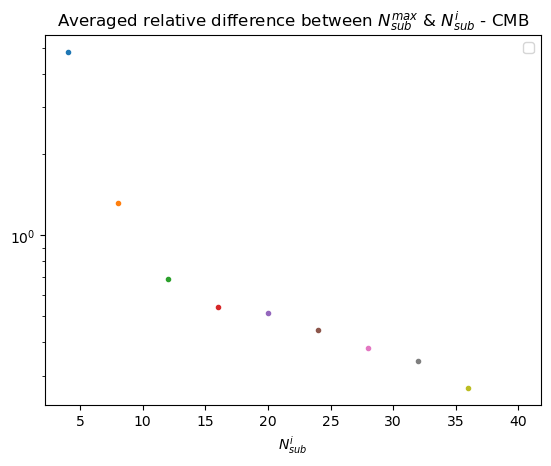

In [19]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

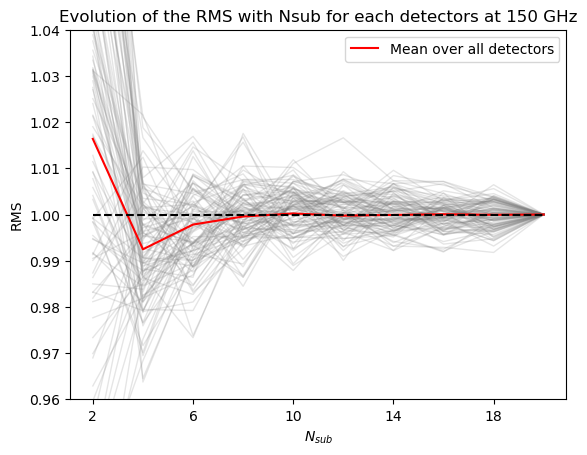

In [20]:
plt.figure()
for idet in range(100):
    plt.plot(nsub_list/2, np.std(TOD_list, axis=2)[:, idet]/np.std(TOD_list, axis=2)[-1, idet], 'grey', alpha=0.2, linewidth=1)
plt.plot(nsub_list/2, np.mean(np.std(TOD_list, axis=2)/np.std(TOD_list, axis=2)[-1], axis=1), 'r', label='Mean over all detectors')
plt.hlines(1, np.min(nsub_list/2), np.max(nsub_list/2), linestyles='--', colors='k')
plt.xlabel(r'$N_{sub}$')
plt.ylabel('RMS')
plt.xticks(nsub_list[::2]/2)
plt.title('Evolution of the RMS with Nsub for each detectors at 150 GHz')
plt.ylim(0.96, 1.04)
plt.legend()

In [21]:
np.std(TOD_list[i][jdet])

1.9384328586762935e-18

# Uniform Sky

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

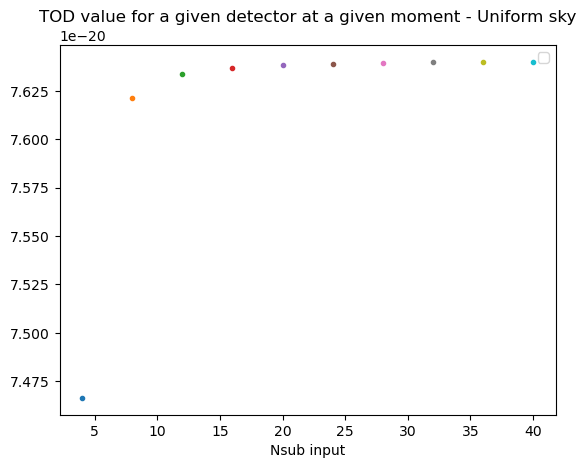

In [22]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_ones_list[i][det_index][sampling_index], '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('TOD value for a given detector at a given moment - Uniform sky')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

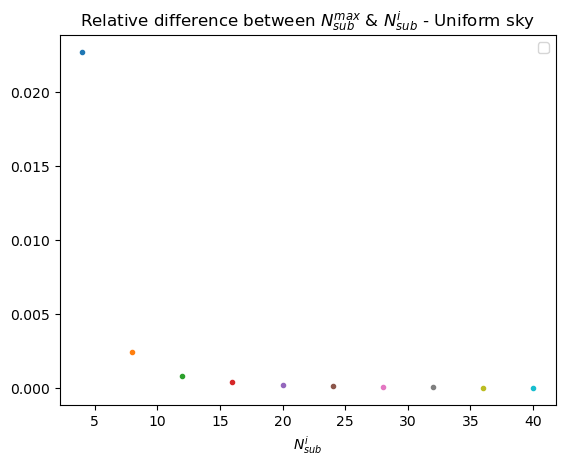

In [23]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_ones_list[-1][det_index, sampling_index] - TOD_ones_list[i][det_index, sampling_index])/TOD_ones_list[-1][det_index, sampling_index]), '.')
plt.legend()
plt.title(r"Relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniform sky")
#plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

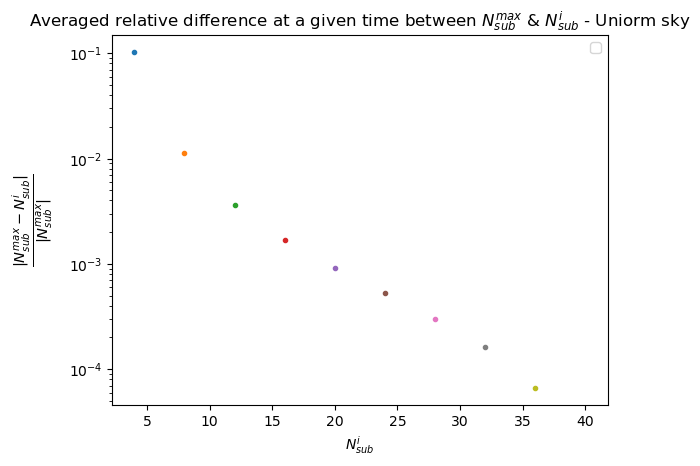

In [24]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones_list[-1][:, sampling_index] - TOD_ones_list[i][:, sampling_index])/TOD_ones_list[-1][:, sampling_index])), '.')
plt.legend()
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniorm sky")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

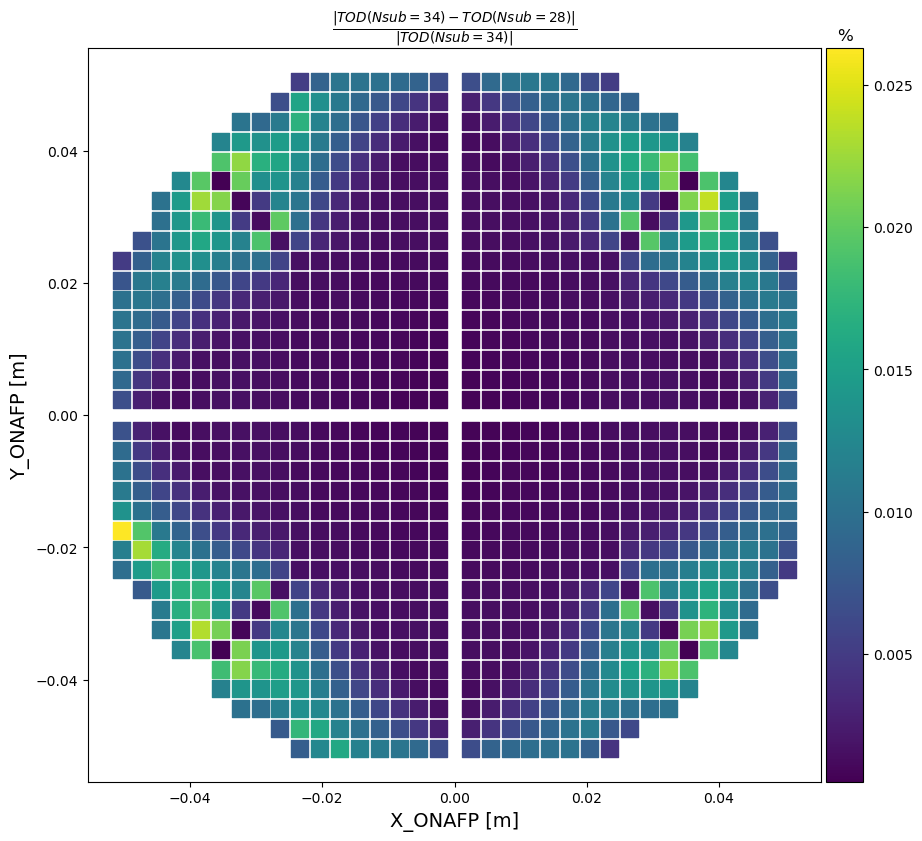

In [25]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones_list[-1] - TOD_ones_list[-2]) / np.abs(TOD_ones_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |}$', fig=fig, ax = ax, unit='%')

In [26]:
stop

NameError: name 'stop' is not defined